In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
#convert image to tensor
transform = transforms.ToTensor()

In [32]:
train_data = datasets.MNIST(root='/cnn_data',train=True , download=True, transform=transform)

In [33]:
#test data
test_data = datasets.MNIST(root='/cnn_data',train=True , download=True, transform=transform)

In [34]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [35]:
test_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [36]:
train_loader = DataLoader(train_data , batch_size=10 , shuffle=True)
test_loader = DataLoader(test_data , batch_size=10 , shuffle=False)

In [37]:
conv1 = nn.Conv2d(1,6,3,1) # 1 image_input , 6 output , 3 filter , 1 stride
conv2 = nn.Conv2d(6, 16,3,1) # 6 input of last layer , 16 output , 3 filter , 1 stride
for i ,(xtrain, ytrain) in enumerate(train_data):
  break


In [38]:
xtrain.shape

torch.Size([1, 28, 28])

In [39]:
# xtrain

In [40]:
x = xtrain.view(1,1,28,28)

In [41]:
x.shape

torch.Size([1, 1, 28, 28])

In [42]:
x = F.relu(conv1(x))


In [43]:
x.shape

# ([1, 6, 26, 26]) #1 is single image , 6 is filter(output of conv1) , 26 size image
# 28 , 28 ====> 26,26 because we dont have padding

torch.Size([1, 6, 26, 26])

In [44]:
x = F.max_pool2d(x , 2,2) #kernel is 2 and stride is 2

In [45]:
x.shape
# ([1, 6, 13, 13]) #1 is single image , 6 is filter(output of conv1) , 26/2 = 13

torch.Size([1, 6, 13, 13])

In [46]:
# second conv2d
x = F.relu(conv2(x))
x.shape
# [1, 16, 11, 11])  # 1 image , 16 output in conv2 ,  11*11 we dont set padding of 13*13

torch.Size([1, 16, 11, 11])

In [47]:
x = F.max_pool2d(x , 2,2)
x.shape
# ([1, 16, 5, 5])   # 1 image , 16 output in conv2 , 11/2=5

torch.Size([1, 16, 5, 5])

In [48]:
#model
class convolutional_network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #fully conected layer
    self.fc1=nn.Linear(5*5*16 , 120)
    self.fc2 = nn.Linear(120 , 84)
    self.fc3 = nn.Linear(84 , 10)

  def forward(self , x ):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x , 2,2) # 2*2 kernel and stride 2
    #second pass
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x , 2,2)

    #review data to flatten
    x = x.view(-1 , 16*5*5)

    #fully connected
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x  , dim =1)



In [49]:
torch.manual_seed(41)
model = convolutional_network()
model

convolutional_network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
#loss func optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [51]:
import time
start_time = time.time()

epochs = 5
train_loss=[]
test_loss=[]
train_correct=[]
test_correct=[]


for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #loop for train
  for b , (x_train , y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(x_train)
    loss = criterion(y_pred , y_train)
    predicted = torch.max(y_pred.data , 1)[1]
    batch_corr = (predicted == y_pred).sum()
    trn_corr += batch_corr

    #update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #result
    if b % 600 == 0:
      print(f'epochs : {i} batch: {b}  loss : {loss.item()}')

  train_loss.append(loss)
  train_correct.append(trn_corr)

#test
  with torch.no_grad():
    for b , (xtest , ytest )in enumerate(test_loader):
      y_val = model(xtest)
      prediction = torch.max(y_val.data, 1)[1]
      tst_corr += (prediction  == ytest).sum()

  loss = criterion(y_val ,ytest)
  test_loss.append(loss)
  test_correct.append(tst_corr)





current_time = time.time()
total = current_time - start_time
print(f'training took : {total / 60} minutes')

epochs : 0 batch: 600  loss : 0.1623610556125641
epochs : 0 batch: 1200  loss : 0.1502392590045929
epochs : 0 batch: 1800  loss : 0.4744560718536377
epochs : 0 batch: 2400  loss : 0.14238706231117249
epochs : 0 batch: 3000  loss : 0.007758188061416149
epochs : 0 batch: 3600  loss : 0.3836284875869751
epochs : 0 batch: 4200  loss : 0.0038223876617848873
epochs : 0 batch: 4800  loss : 0.0021286322735249996
epochs : 0 batch: 5400  loss : 0.0569545142352581
epochs : 0 batch: 6000  loss : 0.00038789428072050214
epochs : 1 batch: 600  loss : 0.005851339548826218
epochs : 1 batch: 1200  loss : 0.3855525553226471
epochs : 1 batch: 1800  loss : 0.004819948226213455
epochs : 1 batch: 2400  loss : 0.003216963727027178
epochs : 1 batch: 3000  loss : 0.0332382395863533
epochs : 1 batch: 3600  loss : 0.5372857451438904
epochs : 1 batch: 4200  loss : 0.04561494290828705
epochs : 1 batch: 4800  loss : 0.0007510822033509612
epochs : 1 batch: 5400  loss : 0.0001173773780465126
epochs : 1 batch: 6000  lo

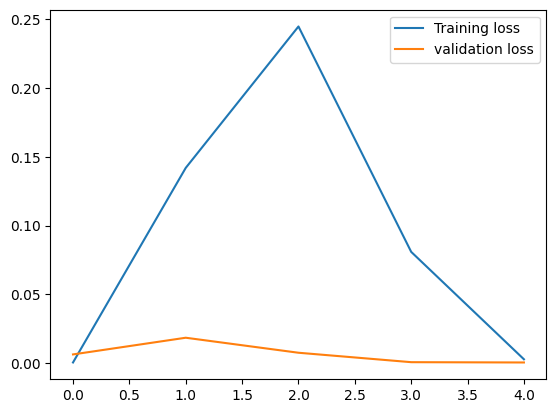

In [52]:
train_loss =[t1.item() for t1 in train_loss]
test_loss =[t1.item() for t1 in test_loss]
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='validation loss')
plt.legend()

In [53]:
test_loader = DataLoader(test_data , batch_size=10000, shuffle=False)

In [54]:
with torch.no_grad():
  correct = 0
  for xtest , ytest in test_loader:
    y_val = model(xtest)
    prediction = torch.max(y_val.data , 1)[1]
    correct += (prediction == ytest).sum()

In [55]:
correct.item()/len(test_data)


0.9901166666666666